In [1]:
import os 
import pandas as pd


In [2]:
calendar = pd.read_csv('../data/calendar.csv')
sales = pd.read_csv('../data/sales_train_validation.csv')
sell_prices = pd.read_csv('../data/sell_prices.csv')

In [3]:
sales['dept_id'].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [4]:
# Load raw CSVs


# Filter sales to only FOOD_1 department
sales = sales[sales['dept_id'] == 'FOODS_1']

# Keep only first 730 day columns (d_1 to d_730)
day_cols = [col for col in sales.columns if col.startswith('d_')]
day_cols_2yrs = day_cols[:730]
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sales = sales[id_cols + day_cols_2yrs]

sales.shape


(2160, 736)

In [5]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_721,d_722,d_723,d_724,d_725,d_726,d_727,d_728,d_729,d_730
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,0,1,...,0,0,2,0,2,0,0,0,1,0
1613,FOODS_1_002_CA_1_validation,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,0,1,0,1,...,2,0,2,0,0,1,0,1,1,1
1614,FOODS_1_003_CA_1_validation,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,0,0,0,0,...,0,1,4,0,0,0,0,0,1,1
1615,FOODS_1_004_CA_1_validation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1616,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,3,9,3,3,...,3,0,1,1,3,2,5,4,0,1


In [6]:
# Melt to long format
sales_long = sales.melt(
    id_vars=id_cols,
    var_name="d",
    value_name="sales"
)

# Merge with calendar
merged = pd.merge(
    sales_long,
    calendar[['d', 'date', 'event_name_1', 'wm_yr_wk', 'snap_CA', 'snap_TX', 'snap_WI']],
    on='d',
    how='left'
)

In [7]:
merged.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,event_name_1,wm_yr_wk,snap_CA,snap_TX,snap_WI
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,NaN,11101,0,0,0
1,FOODS_1_002_CA_1_validation,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,d_1,0,2011-01-29,NaN,11101,0,0,0
2,FOODS_1_003_CA_1_validation,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,d_1,0,2011-01-29,NaN,11101,0,0,0
3,FOODS_1_004_CA_1_validation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,d_1,0,2011-01-29,NaN,11101,0,0,0
4,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,NaN,11101,0,0,0


In [8]:


# Actual working version: pick correct snap column based on state
snap_cols = {'CA': 'snap_CA', 'TX': 'snap_TX', 'WI': 'snap_WI'}
merged['snap'] = merged.apply(lambda row: row[snap_cols[row['state_id']]], axis=1)

# Drop the unused snap columns
merged.drop(columns=['snap_CA', 'snap_TX', 'snap_WI'], inplace=True)

# Merge with sell_prices
merged = pd.merge(
    merged,
    sell_prices,
    on=['store_id', 'item_id', 'wm_yr_wk'],
    how='left'
)

# Fill missing sell_price values
merged['sell_price'] = merged.groupby(['store_id', 'item_id'])['sell_price'].ffill()
merged['sell_price'] = merged.groupby(['store_id', 'item_id'])['sell_price'].bfill()

# Drop unneeded columns
merged.drop(columns=['id', 'wm_yr_wk', 'd'], inplace=True)

merged.head()


,item_id,dept_id,cat_id,store_id,state_id,sales,date,event_name_1,snap,sell_price
0,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,NaN,0,2.00
1,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,0,2011-01-29,NaN,0,7.88
2,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,0,2011-01-29,NaN,0,2.88
3,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0,2011-01-29,NaN,0,1.78
4,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,NaN,0,2.94


In [9]:
merged[merged['sell_price'].isna()]['date'].unique().shape[0]  # Check for any missing sell prices

730

In [10]:
missing_combinations = merged[merged['sell_price'].isna()][['store_id', 'item_id']].drop_duplicates()
print(missing_combinations)

     store_id      item_id
12       CA_1  FOODS_1_014
19       CA_1  FOODS_1_021
20       CA_1  FOODS_1_022
26       CA_1  FOODS_1_028
40       CA_1  FOODS_1_042
...       ...          ...
2130     WI_3  FOODS_1_190
2133     WI_3  FOODS_1_193
2140     WI_3  FOODS_1_200
2142     WI_3  FOODS_1_202
2150     WI_3  FOODS_1_210

[368 rows x 2 columns]


In [11]:
# Merge missing combinations with sales_long to find matching rows
missing_in_sales_long = pd.merge(
    missing_combinations,
    sales_long,
    on=['store_id', 'item_id'],
    how='inner'
)

# Display the result
missing_in_sales_long.head()

,store_id,item_id,id,dept_id,cat_id,state_id,d,sales
0,CA_1,FOODS_1_014,FOODS_1_014_CA_1_validation,FOODS_1,FOODS,CA,d_1,0
1,CA_1,FOODS_1_014,FOODS_1_014_CA_1_validation,FOODS_1,FOODS,CA,d_2,0
2,CA_1,FOODS_1_014,FOODS_1_014_CA_1_validation,FOODS_1,FOODS,CA,d_3,0
3,CA_1,FOODS_1_014,FOODS_1_014_CA_1_validation,FOODS_1,FOODS,CA,d_4,0
4,CA_1,FOODS_1_014,FOODS_1_014_CA_1_validation,FOODS_1,FOODS,CA,d_5,0


In [12]:
# Fill missing sell_price values with 0
merged['sell_price'].fillna(0, inplace=True)


# Verify the result
print("Number of missing sell_price values after filling:", merged['sell_price'].isna().sum())
print(merged.head())

Number of missing sell_price values after filling: 0
       item_id  dept_id cat_id store_id state_id  sales        date  \
0  FOODS_1_001  FOODS_1  FOODS     CA_1       CA      3  2011-01-29   
1  FOODS_1_002  FOODS_1  FOODS     CA_1       CA      0  2011-01-29   
2  FOODS_1_003  FOODS_1  FOODS     CA_1       CA      0  2011-01-29   
3  FOODS_1_004  FOODS_1  FOODS     CA_1       CA      0  2011-01-29   
4  FOODS_1_005  FOODS_1  FOODS     CA_1       CA      3  2011-01-29   

  event_name_1  snap  sell_price  
0          NaN     0        2.00  
1          NaN     0        7.88  
2          NaN     0        2.88  
3          NaN     0        1.78  
4          NaN     0        2.94  


C:\Users\Maaz Ahmad\AppData\Local\Temp\ipykernel_2260\184118768.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged['sell_price'].fillna(0, inplace=True)


In [13]:
num_cols = merged.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = merged.select_dtypes(include=['object']).columns.tolist()

In [14]:
num_cols

['sales', 'snap', 'sell_price']

In [15]:
cat_cols

['item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'date',
 'event_name_1']

In [16]:
merged['date'] = merged['date'].astype('datetime64[ns]')
# Convert date to datetime format
#make date col the index
merged.set_index('date', inplace=True)
# Sort by date
merged.sort_index(inplace=True)
merged.head()

,item_id,dept_id,cat_id,store_id,state_id,sales,event_name_1,snap,sell_price
date,,,,,,,,,
2011-01-29,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,NaN,0,2.00
2011-01-29,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,0,NaN,0,7.88
2011-01-29,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,0,NaN,0,2.88
2011-01-29,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0,NaN,0,1.78
2011-01-29,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,3,NaN,0,2.94


## Data Transformation and Analysis

In [17]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [18]:
sample = merged.iloc[:365].copy()


In [19]:
num_cols = ['sales', 'sell_price']
cat_cols = ['item_id', 'store_id', 'state_id', 'event_name_1','snap']
sample = sample[num_cols + cat_cols].copy()
sample.head()

,sales,sell_price,item_id,store_id,state_id,event_name_1,snap
date,,,,,,,
2011-01-29,3,2.00,FOODS_1_001,CA_1,CA,NaN,0
2011-01-29,0,7.88,FOODS_1_002,CA_1,CA,NaN,0
2011-01-29,0,2.88,FOODS_1_003,CA_1,CA,NaN,0
2011-01-29,0,1.78,FOODS_1_004,CA_1,CA,NaN,0
2011-01-29,3,2.94,FOODS_1_005,CA_1,CA,NaN,0


In [20]:
agg = merged.groupby([merged.index,'store_id']).agg({
    'sales':'sum',
    'sell_price':'mean',
    'snap':'mean',
    'event_name_1':'first'
})


#### check event correlation with sales

C:\Users\Maaz Ahmad\AppData\Local\Temp\ipykernel_2260\3273582773.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=event_summary, x='event_name_1', y='sales', palette='viridis')


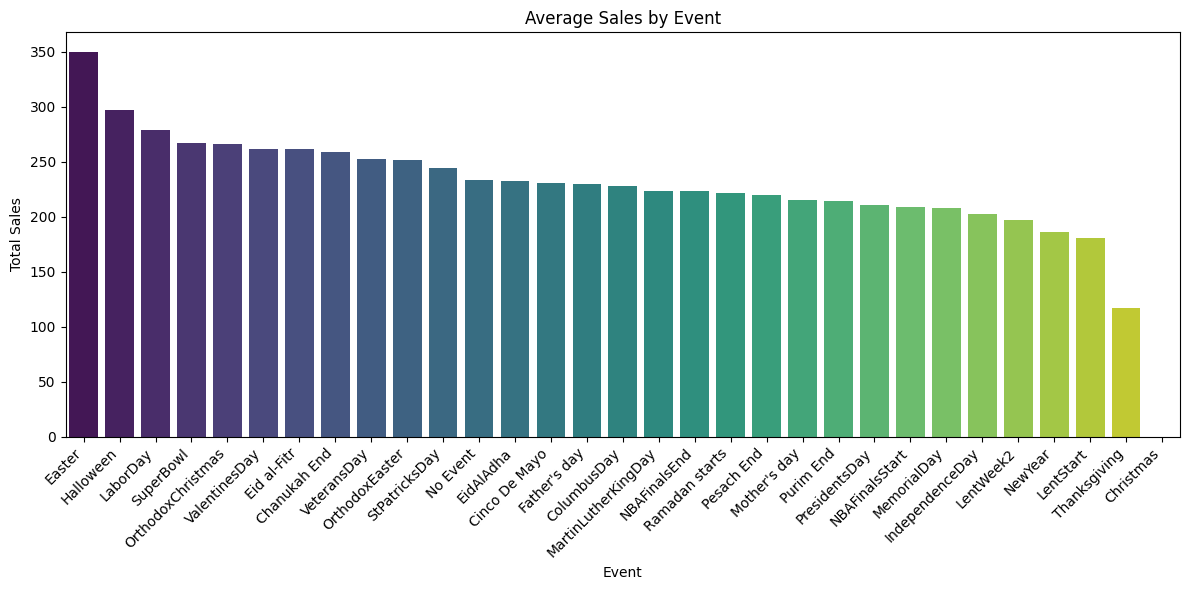

In [21]:
event_sales = agg.copy()

# Fill NaNs in event_name_1 for non-event days
event_sales['event_name_1'] = event_sales['event_name_1'].fillna('No Event')

# Group by event
event_summary = event_sales.groupby('event_name_1')['sales'].mean().reset_index()

# Sort by sales for better viz
event_summary = event_summary.sort_values(by='sales', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=event_summary, x='event_name_1', y='sales', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Average Sales by Event")
plt.xlabel("Event")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()



In [22]:
agg['is_event'] = agg['event_name_1'].apply(lambda x: 0 if x == 'No Event' else 1)
agg['is_event'] = agg['is_event'].astype('int')
agg['week_before_event'] = agg['is_event'].shift(7).fillna(0).astype('int')
agg['week_after_event'] = agg['is_event'].shift(-7).fillna(0).astype('int')
agg['dayofweek'] = agg.index.get_level_values(0).dayofweek
agg['day'] = agg.index.get_level_values(0).day
agg['month'] = agg.index.get_level_values(0).month
agg['is_weekend'] = agg['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
agg['is_weekend'] = agg['is_weekend'].astype('int')
agg['lag_1'] = agg['sales'].shift(1).fillna(0)
agg['lag_7'] = agg['sales'].shift(7).fillna(0)
agg['lag_14'] = agg['sales'].shift(14).fillna(0)
agg['rolling_mean_7'] = agg['sales'].rolling(window=7).mean().shift(1).fillna(0)
agg.drop(columns=['event_name_1'], inplace=True)


In [23]:
final = agg.reset_index().set_index('date')

In [24]:
final.head()

,store_id,sales,sell_price,snap,is_event,week_before_event,week_after_event,dayofweek,day,month,is_weekend,lag_1,lag_7,lag_14,rolling_mean_7
date,,,,,,,,,,,,,,,
2011-01-29,CA_1,297,2.562222,0.0,1,0,1,5,29,1,1,0.0,0.0,0.0,0.0
2011-01-29,CA_2,406,2.585694,0.0,1,0,1,5,29,1,1,297.0,0.0,0.0,0.0
2011-01-29,CA_3,341,2.609167,0.0,1,0,1,5,29,1,1,406.0,0.0,0.0,0.0
2011-01-29,CA_4,113,2.493009,0.0,1,0,1,5,29,1,1,341.0,0.0,0.0,0.0
2011-01-29,TX_1,152,2.840787,0.0,1,0,1,5,29,1,1,113.0,0.0,0.0,0.0


In [25]:
final['days_since_start'] = (final.index - final.index[0]).days.astype('int')

In [26]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')  # sparse_output for latest sklearn
agg_encoded = encoder.fit_transform(final[['store_id']])
final[encoder.get_feature_names_out(['store_id'])] = agg_encoded

final.drop(columns=['store_id'], inplace=True)
final.head()


,sales,sell_price,snap,is_event,week_before_event,week_after_event,dayofweek,day,month,is_weekend,...,days_since_start,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,297,2.562222,0.0,1,0,1,5,29,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-29,406,2.585694,0.0,1,0,1,5,29,1,1,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-29,341,2.609167,0.0,1,0,1,5,29,1,1,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-29,113,2.493009,0.0,1,0,1,5,29,1,1,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-29,152,2.840787,0.0,1,0,1,5,29,1,1,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Get lastknown info

In [1]:
import pandas as pd
import os

In [40]:
import pandas as pd

df = pd.read_csv("../../artifact/X_test.csv")
sales  = pd.read_csv("../../artifact/y_test.csv")  
last_date  = pd.to_datetime('2013-01-27')
initial_days_since_start = df['days_since_start'].iloc[0]

# Filter data for a specific store (CA_2 here as an example)
historical_sales = df[df['store_id_CA_2'] == 1].copy()
sales = sales.loc[historical_sales.index]

# We'll work with this as our known sales
sales = sales.squeeze()
past_sales = list(sales[-14:].values)  

# Define forecast horizon
days_to_forecast = 7
last_date = pd.to_datetime('2013-01-27')  # Last known date
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_forecast)

# Store previous predictions
predicted_sales = []
forecast_rows = []



for i, date in enumerate(forecast_dates):
    dayofweek = date.dayofweek
    row = {
        "dayofweek": dayofweek,
        "day": date.day,
        "month": date.month,
        "is_weekend": int(dayofweek >= 5),
        "days_since_start": initial_days_since_start + i+1,
        "is_event": 0,
        "snap": 0,  
        "store_id_CA_2": 1,
        "store_id_CA_3": 0,
        "store_id_TX_1": 0,
        "store_id_TX_2": 0,
        "store_id_TX_3": 0,
        "store_id_WI_1": 0,
        "store_id_WI_2": 0,
        "store_id_WI_3": 0,
        "lag_1": past_sales[-1],
        "lag_7": past_sales[-7],
        "lag_14": past_sales[-14],
    }

   

   

    forecast_rows.append(row)

    # ---- Model prediction here ----
    # Example dummy prediction for testing
    fake_pred = 20 + i  # Replace with: model.predict(pd.DataFrame([row]))
    predicted_sales.append(fake_pred)
    past_sales.append(fake_pred)
    if len(past_sales) > 14:
        past_sales = past_sales[-14:]

# Final DataFrame
forecast_df = pd.DataFrame(forecast_rows)


In [42]:
forecast_df.head(10)

,dayofweek,day,month,is_weekend,days_since_start,is_event,snap,store_id_CA_2,store_id_CA_3,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,lag_1,lag_7,lag_14
0,0,28,1,0,468,0,0,1,0,0,0,0,0,0,0,501,365,408
1,1,29,1,0,469,0,0,1,0,0,0,0,0,0,0,20,430,420
2,2,30,1,0,470,0,0,1,0,0,0,0,0,0,0,21,425,463
3,3,31,1,0,471,0,0,1,0,0,0,0,0,0,0,22,544,603
4,4,1,2,0,472,0,0,1,0,0,0,0,0,0,0,23,606,655
5,5,2,2,1,473,0,0,1,0,0,0,0,0,0,0,24,702,571
6,6,3,2,1,474,0,0,1,0,0,0,0,0,0,0,25,501,383


In [35]:
sales.head()

1     360
11    344
21    507
31    406
41    295
Name: sales, dtype: int64

,sell_price,snap,is_event,dayofweek,day,month,is_weekend,days_since_start,lag_1,lag_7,lag_14,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3
1,3.441047,1.0,1,3,10,5,0,467,255.0,255.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,3.441047,0.0,1,4,11,5,0,468,360.0,255.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,3.441047,0.0,1,5,12,5,1,469,344.0,255.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,3.441047,0.0,1,6,13,5,1,470,507.0,255.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,3.441047,0.0,1,0,14,5,0,471,406.0,255.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,3.441047,0.0,1,1,15,5,0,472,295.0,255.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,3.441047,0.0,1,2,16,5,0,473,300.0,255.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71,3.441047,0.0,1,3,17,5,0,474,303.0,360.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,3.441047,0.0,1,4,18,5,0,475,317.0,344.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,3.441628,0.0,1,5,19,5,1,476,360.0,507.0,255.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
